<h1 data-start="100" data-end="197"><span style="background-color: #bfedd2;">Transfer Learning con MobileNetV2 para Clasificaci&oacute;n de Flores&nbsp;</span></h1>
<div id="gtx-trans" style="position: absolute; left: -86px; top: 38.2344px;">
<div class="gtx-trans-icon">&nbsp;</div>
</div>

## Objetivo

<p style="text-align: justify;">Aplicar la t&eacute;cnica de transfer learning utilizando el modelo MobileNetV2 preentrenado para desarrollar un sistema eficiente de clasificaci&oacute;n de las 102 especies florales del dataset Oxford Flowers 102, optimizando la precisi&oacute;n del modelo y evaluando su desempe&ntilde;o en la identificaci&oacute;n correcta de las diferentes clases de flores.</p>

<h3 data-start="217" data-end="248">Sobre M&iacute;</h3>
<p data-start="249" data-end="620">Como analista de datos junior, busco aplicar mis conocimientos en an&aacute;lisis exploratorio, visualizaci&oacute;n y modelos predictivos para aportar valor en la toma de decisiones basada en datos. Me interesa crecer en entornos colaborativos donde pueda aprender de proyectos reales, desarrollar soluciones con impacto y continuar form&aacute;ndome en ciencia de datos aplicada al negocio. Tengo experiencia pr&aacute;ctica en limpieza de datos, visualizaci&oacute;n con herramientas como Matplotlib y Seaborn, y creaci&oacute;n de modelos b&aacute;sicos con scikit-learn y redes neuronales en Keras.&nbsp;</p>
<h6 style="text-align: right;" data-start="249" data-end="620">Romero Olmos, Luis Eduardo<br />Correo: <a href="mailto:luiseduardoromeroolmos@aol.com">luiseduardoromeroolmos@aol.com</a><br />Git: https://github.com/LuisEduardoRomeroOlmos<br />Kaggle: https://www.kaggle.com/luiseduardoromeroolm</h6>

## Importacion de librerias

In [52]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<p><em><strong>Declaraci&oacute;n de Funciones</strong></em></p>

In [53]:
#Funcion para graficar el historial de entrenamiento
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.xlabel('Época')
    plt.ylabel('Exactitud')
    plt.title('Evolución del Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [54]:
def cargar_preprocesar_imagen(ruta_imagen, tamaño=(128, 128)):
    # Cargar y redimensionar
    img = image.load_img(ruta_imagen, target_size=tamaño)
    # Convertir a array
    img_array = image.img_to_array(img)
    # Añadir dimensión para lote (batch size 1)
    img_array = np.expand_dims(img_array, axis=0)
    # Escalar píxeles a rango [0, 1]
    img_array = img_array / 255.0
    return img_array

## Preparacion y Aumento de Datos para el Modelo CNN

<p data-start="131" data-end="635">Se utiliza <strong>ImageDataGenerator</strong> para aplicar t&eacute;cnicas de aumento de datos que enriquecen el conjunto de entrenamiento, mejorando as&iacute; la capacidad de generalizaci&oacute;n del modelo. Entre estas t&eacute;cnicas se incluyen rotaciones de hasta 30&deg;, desplazamientos horizontales y verticales del 10%, transformaciones por corte (shear), zoom aleatorio dentro del rango 0.8&ndash;1.2, y volteo horizontal. Adem&aacute;s, se emplea el modo de relleno 'nearest' para completar los p&iacute;xeles generados por las transformaciones.</p>
<p data-start="637" data-end="758">El conjunto de datos se divide previamente en tres carpetas: train y val, y se cargan de la siguiente manera:</p>
<ul data-start="760" data-end="983">
<li data-start="760" data-end="827">
<p data-start="762" data-end="827"><strong>train_data</strong> se genera con<strong> aumentos y</strong> <strong>reescalado</strong> de im&aacute;genes.</p>
</li>
<li data-start="828" data-end="983">
<p data-start="830" data-end="983"><strong>val_data</strong> &nbsp;se carga solo con<strong> reescalado</strong>, manteni&eacute;ndose sin transformaciones adicionales para evaluar el desempe&ntilde;o real del modelo.</p>
</li>
</ul>
<p data-start="985" data-end="1218">El tama&ntilde;o objetivo de las im&aacute;genes es de <strong>224x224 p&iacute;xeles</strong>, el <strong>batch_size es de 32</strong>&nbsp;y se emplea la <strong>codificaci&oacute;n sparse</strong> para las etiquetas, lo cual es adecuado al usar <strong>sparse_categorical_crossentropy</strong> como funci&oacute;n de p&eacute;rdida.</p>

In [64]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,         # Aumentar un poco el rango de rotación (hasta 30°)
    width_shift_range=0.1,     # Mover horizontalmente la imagen un 10%
    height_shift_range=0.1,    # Mover verticalmente la imagen un 10%
    shear_range=0.15,          # Aplicar una transformación de corte (shear)
    zoom_range=0.2,            # Zoom dentro del rango 0.8 a 1.2
    horizontal_flip=True,      # Voltear horizontalmente
    fill_mode='nearest'        # Relleno para los píxeles que queden vacíos después de la transformación  
)

val_test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    'Dataset/Split/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

val_data = val_test_gen.flow_from_directory(
    'Dataset/Split/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

Found 6507 images belonging to 102 classes.
Found 1682 images belonging to 102 classes.


## Creación e importación del Modelo

<p data-start="130" data-end="421">Se utiliz&oacute; la arquitectura <strong data-start="157" data-end="197">MobileNetV2 preentrenada en ImageNet</strong> como base para el modelo. Esta red se carga sin su capa superior (include_top=False) y se configura inicialmente con todas sus capas <strong data-start="333" data-end="347">congeladas</strong> (trainable=False) para preservar el conocimiento previamente aprendido.</p>
<p data-start="423" data-end="572">Sobre esta base se construye una nueva "cabeza" de clasificaci&oacute;n adaptada a la tarea de distinguir entre 102 especies de flores. Esta cabeza incluye:</p>
<ul data-start="574" data-end="923">
<li data-start="574" data-end="655">
<p data-start="576" data-end="655">Una capa de <strong data-start="588" data-end="614">GlobalAveragePooling2D</strong> para reducir las dimensiones espaciales,</p>
</li>
<li data-start="656" data-end="755">
<p data-start="658" data-end="755">Una capa <strong data-start="667" data-end="712">densa de 256 unidades con activaci&oacute;n ReLU</strong> para incrementar la capacidad de decisi&oacute;n,</p>
</li>
<li data-start="756" data-end="813">
<p data-start="758" data-end="813">Una capa <strong data-start="767" data-end="786">Dropout del 50%</strong> para prevenir sobreajuste,</p>
</li>
<li data-start="814" data-end="923">
<p data-start="816" data-end="923">Una capa de salida con <strong data-start="839" data-end="861">activaci&oacute;n softmax</strong> adecuada para la clasificaci&oacute;n multiclase con 102 categor&iacute;as.</p>
</li>
</ul>
<p data-start="925" data-end="1100">El modelo se compila usando el optimizador <strong data-start="968" data-end="976">Adam</strong> y la funci&oacute;n de p&eacute;rdida <strong data-start="1001" data-end="1036">sparse_categorical_crossentropy</strong>, com&uacute;nmente utilizada en problemas de clasificaci&oacute;n multiclase.</p>

In [12]:
# Cargar el modelo base (sin la capa final)
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

In [13]:
#  Congelas las capas de MobileNet
base_model.trainable = False  

In [14]:
# Crear la cabeza del modelo (clasificación binaria)
head_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),      # Reduce las características espaciales
    layers.Dense(256, activation='relu'), # Capa densa más grande para más capacidad
    layers.Dropout(0.5),                   # Regularización para evitar sobreajuste
    layers.Dense(102, activation='softmax')  # Salida con 102 clases (flores)
])

In [15]:
# Compilar solo la cabeza
head_model.compile( optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [16]:
head_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 102)            │        26,214 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,612,134 (9.96 MB)

 Trainable params: 354,150 (1.35 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Entrenamiento del modelo

#### Entrenamiento de la cabeza

El entrenamiento de la cabeza (o training the head en inglés) se refiere a entrenar solo la parte superior de un modelo basado en transfer learning, es decir, las capas que tú agregas al final del modelo base preentrenado.

In [17]:
# Entrenar solo la cabeza 20, maximo 20
history = head_model.fit(train_data, validation_data=val_data, epochs=20)

Epoch 1/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.1708 - loss: 3.8924 - val_accuracy: 0.6421 - val_loss: 1.5693
Epoch 2/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 348s 2s/step - accuracy: 0.5322 - loss: 1.7847 - val_accuracy: 0.7598 - val_loss: 0.9587
Epoch 3/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 316s 2s/step - accuracy: 0.6569 - loss: 1.2353 - val_accuracy: 0.8193 - val_loss: 0.7275
Epoch 4/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.7074 - loss: 1.0079 - val_accuracy: 0.8413 - val_loss: 0.5935
Epoch 5/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.7691 - loss: 0.8151 - val_accuracy: 0.8502 - val_loss: 0.5630
Epoch 6/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.7860 - loss: 0.7154 - val_accuracy: 0.8555 - val_loss: 0.5282
Epoch 7/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.8041 - loss: 0.6730 - val_accuracy: 0.8662 - val_loss: 0.4765
Epoch 8/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 397s 2s/step - accuracy: 0.8200 - loss: 0.5956 - val_accu

####  Fine-Tuning del Modelo Preentrenado

En esta sección se realiza el **fine-tuning** de MobileNetV2, desbloqueando las últimas 25 capas para permitir que se ajusten mejor a la tarea de clasificación. Las primeras 130 capas se mantienen congeladas para conservar el conocimiento aprendido previamente en ImageNet.

El modelo se recompila con una **tasa de aprendizaje baja (`1e-5`)**, ideal para ajustes finos sin afectar negativamente los pesos preentrenados.

Se utilizan los siguientes *callbacks* para controlar el entrenamiento:

- **`EarlyStopping`**: detiene el entrenamiento si `val_accuracy` no mejora tras 12 épocas.
- **`ModelCheckpoint`**: guarda automáticamente el mejor modelo según la precisión de validación.
- **`ReduceLROnPlateau`**: reduce la tasa de aprendizaje si `val_loss` se estanca, afinando el aprendizaje.

Finalmente, se entrena el modelo con estas configuraciones por un máximo de 15 épocas.


In [18]:
# Descongelar algunas capas profundas
base_model.trainable = True

# Congelar las primeras N capas, entrenar las últimas (más específicas)
for layer in base_model.layers[:130]:
    layer.trainable = False

# Recompilar antes de continuar
head_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # tasa más baja
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [20]:
# EarlyStopping para detener entrenamiento si val_accuracy no mejora en 5 épocas seguidas
early_stop = EarlyStopping(
    monitor='val_accuracy',  # métrica a monitorear
    patience=12,              # espera 12 epochs sin mejora para detener
    verbose=1,
    restore_best_weights=True  # restaura los pesos del mejor epoch al final
)

# ModelCheckpoint para guardar el mejor modelo durante el entrenamiento
checkpoint = ModelCheckpoint(
    'Flores_Version_2_C.keras',       # ruta donde se guardará el modelo
    monitor='val_accuracy',  # métrica a monitorear
    save_best_only=True,     # guarda solo el mejor modelo
    verbose=1
)

# reduce a la mitad (de 1e-5 a 5e-6, luego a 2.5e-6, etc.)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,        
    patience=4,        # si val_loss no mejora en 7 épocas, reduce LR
    verbose=1,
    min_lr=1e-7        # no baja de 1e-7
)


In [21]:
# Entrenamos el modelo con las capas descongeladas (25) 
history = head_model.fit(
    train_data,
    validation_data=val_data,
    epochs=60,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/60
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5353 - loss: 2.1033
Epoch 1: val_accuracy improved from -inf to 0.89120, saving model to Flores_Version_2_C.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 379s 2s/step - accuracy: 0.5356 - loss: 2.1012 - val_accuracy: 0.8912 - val_loss: 0.4116 - learning_rate: 1.0000e-05
Epoch 2/60
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7220 - loss: 0.9546
Epoch 2: val_accuracy improved from 0.89120 to 0.89358, saving model to Flores_Version_2_C.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 367s 2s/step - accuracy: 0.7221 - loss: 0.9542 - val_accuracy: 0.8936 - val_loss: 0.4050 - learning_rate: 1.0000e-05
Epoch 3/60
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7815 - loss: 0.7326
Epoch 3: val_accuracy did not improve from 0.89358
204/204 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.7815 - loss: 0.7324 - val_accuracy: 0.8936 - val_loss: 0.3904 - learning_rate: 1.0000e-05
Epoch 4/60
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.

#### Evolución del Accuracy por época.

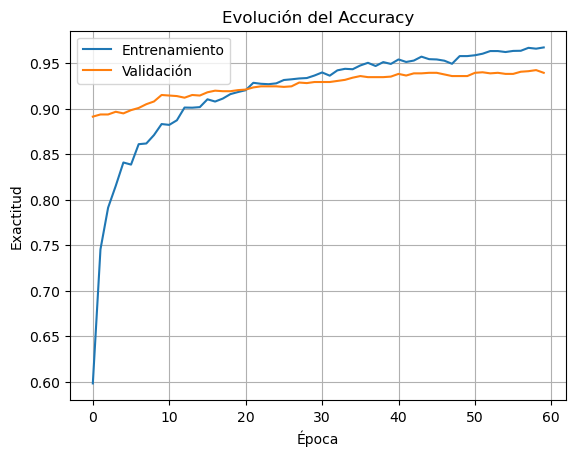

In [56]:
#Evolucion del Accuracy del primer entrenamiento con descongelar las capas
plot_accuracy(history)

### Comprobación Mediante el Conjunto de Prueba

In [65]:
#Cargar mejor modelos
from tensorflow.keras.models import load_model
modelo = load_model("Flores_Version_2_C.keras")

#### Prediccion sobre el conjunto de Prueba

In [66]:
#Obtenemos la matriz de Probabilidades
y_probs = modelo.predict(val_data, verbose=1)

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 837ms/step


In [67]:
# Si tienes one-hot o probabilidades:
y_pred = np.argmax(y_probs, axis=1)  # predicción final por clase

In [68]:
# Esto te da los 0s y 1s reales del test_set
y_true = val_data.classes  

In [69]:
#  Obtener nombres de clases (opcional, si quieres que el reporte sea legible)
class_names = list(val_data.class_indices.keys())

#### Metricas sobre el conjunto de Prueba

In [70]:
#Accuracy, precision, recall y f-score
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        12
           2       0.76      0.89      0.82        18
           3       0.80      1.00      0.89        12
           4       1.00      0.90      0.95        10
           5       0.94      0.94      0.94        18
           6       1.00      1.00      1.00        10
           7       1.00      1.00      1.00        10
           8       0.91      1.00      0.95        10
           9       0.80      0.89      0.84         9
          10       0.94      1.00      0.97        17
          11       1.00      1.00      1.00        17
          12       0.83      1.00      0.91        10
          13       0.92      0.92      0.92        12
          14       1.00      0.38      0.55         8
          15       1.00      1.00      1.00         8
          16       0.92      1.00      0.96        12
          17       0.95    

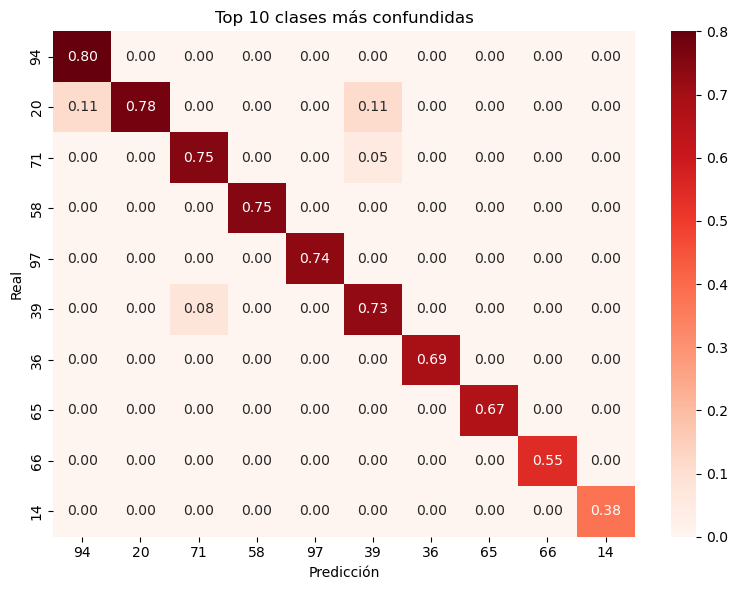

In [71]:
# Matriz de confusión normalizada
cm = confusion_matrix(y_true, y_pred, normalize='true')

# Errores por clase: total menos aciertos
errors = np.sum(cm, axis=1) - np.diag(cm)
top_classes = np.argsort(errors)[-10:]  # las 10 más problemáticas

# Submatriz para esas clases
cm_top = cm[np.ix_(top_classes, top_classes)]

# Mostrar
plt.figure(figsize=(8, 6))
sns.heatmap(cm_top, annot=True, fmt=".2f", cmap="Reds", 
            xticklabels=top_classes, yticklabels=top_classes)
plt.title("Top 10 clases más confundidas")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

<h3 data-start="153" data-end="188"><strong data-start="160" data-end="188">Conclusi&oacute;n:</strong></h3>
<p data-start="190" data-end="413">El modelo basado en <strong data-start="210" data-end="225">MobileNetV2</strong> con una cabeza densa de 256 unidades y activaci&oacute;n <strong data-start="276" data-end="287">softmax</strong>, evaluado sobre un conjunto de validaci&oacute;n de <strong data-start="333" data-end="377">1682 im&aacute;genes distribuidas en 102 clases</strong>, alcanz&oacute; los siguientes resultados:</p>
<ul data-start="415" data-end="538">
<li data-start="415" data-end="448">
<p data-start="417" data-end="448"><strong data-start="420" data-end="439">Accuracy global</strong>: <strong data-start="441" data-end="448">94%</strong></p>
</li>
<li data-start="449" data-end="491">
<p data-start="451" data-end="491"><strong data-start="454" data-end="481">F1-score macro promedio</strong>: <strong data-start="483" data-end="491">0.94</strong></p>
</li>
<li data-start="492" data-end="538">
<p data-start="494" data-end="538"><strong data-start="497" data-end="528">F1-score ponderado promedio</strong>: <strong data-start="530" data-end="538">0.94</strong></p>
</li>
</ul>
<p data-start="540" data-end="750">Estos resultados reflejan un desempe&ntilde;o altamente competitivo, especialmente considerando el tama&ntilde;o relativamente peque&ntilde;o del dataset y la complejidad de una clasificaci&oacute;n multiclase con 102 etiquetas distintas.</p>
<p data-start="1005" data-end="1103">Aunque el desempe&ntilde;o es sobresaliente, algunas clases a&uacute;n presentan espacio de mejora. Por ejemplo:</p>
<ul data-start="1105" data-end="1224">
<li data-start="1105" data-end="1128">
<p data-start="1107" data-end="1128">Clase 14: F1 = 0.55</p>
</li>
<li data-start="1129" data-end="1152">
<p data-start="1131" data-end="1152">Clase 66: F1 = 0.71</p>
</li>
<li data-start="1153" data-end="1176">
<p data-start="1155" data-end="1176">Clase 65: F1 = 0.80</p>
</li>
<li data-start="1177" data-end="1200">
<p data-start="1179" data-end="1200">Clase 36: F1 = 0.82</p>
</li>
<li data-start="1201" data-end="1224">
<p data-start="1203" data-end="1224">Clase 97: F1 = 0.78</p>
</li>
</ul>
<p data-start="1226" data-end="1248">Esto podr&iacute;a deberse a:</p>
<ul data-start="1249" data-end="1396">
<li data-start="1249" data-end="1299">
<p data-start="1251" data-end="1299">Im&aacute;genes visualmente similares con otras clases,</p>
</li>
<li data-start="1300" data-end="1335">
<p data-start="1302" data-end="1335">Variabilidad intra-clase elevada,</p>
</li>
<li data-start="1336" data-end="1396">
<p data-start="1338" data-end="1396">O menos ejemplos representativos durante el entrenamiento.</p>
</li>
</ul>

<h3 data-start="131" data-end="163">Recomendaciones de Mejora</h3>
<p data-start="165" data-end="340">Algunas recomendaciones ya se realizaron y fueron descartadas. Las siguientes propuestas corresponden a posibles pruebas futuras para seguir mejorando el desempe&ntilde;o del modelo:</p>
<ul data-start="342" data-end="1409">
<li data-start="342" data-end="628">
<p data-start="344" data-end="628"><strong data-start="344" data-end="400">Validaci&oacute;n cruzada estratificada (Stratified K-Fold)</strong>: Implementar <code data-start="414" data-end="431">StratifiedKFold</code> para evaluar si el modelo mantiene un desempe&ntilde;o consistente al entrenarse y evaluarse en distintos subconjuntos del conjunto de datos. Esto puede ofrecer una mejor estimaci&oacute;n de su generalizaci&oacute;n.</p>
</li>
<li data-start="630" data-end="894">
<p data-start="632" data-end="894"><strong data-start="632" data-end="673">Descongelar m&aacute;s capas del modelo base</strong>: Actualmente solo se entrena la cabeza del modelo. Una mejora ser&iacute;a descongelar gradualmente m&aacute;s capas de MobileNetV2 para que el modelo adapte mejor sus representaciones a la tarea espec&iacute;fica de clasificaci&oacute;n de flores.</p>
</li>
<li data-start="896" data-end="1164">
<p data-start="898" data-end="1164"><strong data-start="898" data-end="938">Mayor n&uacute;mero de fases de Fine-Tuning</strong>: Realizar el entrenamiento en varias fases, descongelando capas en bloques, con tasas de aprendizaje m&aacute;s peque&ntilde;as, para mejorar progresivamente la especializaci&oacute;n del modelo sin perder la generalizaci&oacute;n adquirida en ImageNet.</p>
</li>
<li data-start="1166" data-end="1409">
<p data-start="1168" data-end="1409"><strong data-start="1168" data-end="1203">Optimizaci&oacute;n de hiperpar&aacute;metros</strong>: Usar herramientas como <code data-start="1228" data-end="1240">KerasTuner</code>, <code data-start="1242" data-end="1250">Optuna</code> o b&uacute;squeda bayesiana para ajustar autom&aacute;ticamente par&aacute;metros clave como tasa de aprendizaje, n&uacute;mero de unidades en capas densas, tasa de dropout o batch size.</p>
</li>
</ul>

## StreamLit

<h3 data-start="112" data-end="174">Aplicaci&oacute;n Web de Clasificaci&oacute;n de Flores&nbsp;</h3>
<p data-start="176" data-end="335">Se desarroll&oacute; una aplicaci&oacute;n interactiva en <strong data-start="220" data-end="233">Streamlit</strong> disponible en:<br data-start="248" data-end="251" />🔗 <a class="" href="https://clasificacion-flores.streamlit.app/" target="_new" rel="noopener" data-start="254" data-end="335">clasificacion-flores.streamlit.app</a></p>
<p data-start="337" data-end="575">Esta aplicaci&oacute;n permite a los usuarios subir im&aacute;genes de flores y obtener una predicci&oacute;n autom&aacute;tica de su especie entre 102 clases diferentes, basada en el mejor modelo entrenado con Transfer Learning utilizando MobileNetV2.</p>
<p data-start="577" data-end="735">El modelo fue ajustado espec&iacute;ficamente para el conjunto de datos Oxford Flowers 102, alcanzando un accuracy del 94%, con una arquitectura que incluye:</p>
<p data-start="902" data-end="962">La app ofrece una experiencia r&aacute;pida e intuitiva, mostrando:</p>
<ul data-start="963" data-end="1061">
<li data-start="963" data-end="982">
<p data-start="965" data-end="982">la imagen subida,</p>
</li>
<li data-start="983" data-end="1023">
<p data-start="985" data-end="1023">la clase predicha (nombre de la flor),</p>
</li>
<li data-start="1024" data-end="1061">
<p data-start="1026" data-end="1061">y el nivel de confianza del modelo.</p>
</li>
<li data-start="1024" data-end="1061">Un top 5 de posibles.</li>
<li data-start="1024" data-end="1061">Una breve descripci&oacute;n de Wikipedia</li>
</ul>